# Getting Started 

Reference: https://github.com/ArgoCanada/meds-dmqc/blob/main/report/notebooks/01_active/4900637_report.ipynb

## DMQC Report: WMO 7902199 

In [1]:
#pip install bgcArgoDMQC

In [10]:
import os
print(os.getcwd())  # show current working directory
from pathlib import Path

C:\Users\jojob\NOAA Lapenta Code\bgcArgoDMQC\no3_DMQC


In [9]:
from pathlib import Path

# Set it to where your notebook or files live
working_dir = Path("C:/Users/jojob/NOAA Lapenta Code/bgcArgoDMQC/no3_DMQC")
os.chdir(working_dir)  # change working directory
print(Path.cwd())

C:\Users\jojob\NOAA Lapenta Code\bgcArgoDMQC\no3_DMQC


In [12]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 7902199  # insert WMO number here
#fig_path = Path("NOAA Lapenta Code/NO3_DMQC_Prep/bcgArgo_figs") / f"{wmo}" # where to save figures
#fig_path.mkdir(parents=True, exist_ok=True)
#bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec

Calculating gains using WOA surface data and float O2 percent saturation...
1.0267052382522905


## DOXY Audit Status
* If the float has any profiles present in the DOXY audit, which are they are why?
* Likely will usually be left empty/deleted

In [14]:
audit_file = Path(r"C:\Users\jojob\NOAA Lapenta Code\bgcArgoDMQC\no3_DMQC\DOXY_WOA_audit_101524.TXT")
df = pd.read_csv(audit_file, sep='\t', header=25)
df = df.loc[df.WMO == wmo]
df['date'] = [datestr2num(t) for t in df['profile date']]
print(df)

Empty DataFrame
Columns: [DAC, PI, SPROF DATE_UPDATE, DATA MODE, WMO, cycle, profile date, lon, lat, WOA T, WOA S, WOA O2 %sat, PRES, TEMP, PSAL, flt O2 %sat, flt O2adj %sat, WOA G_raw, WOA G_adj, Z_WOAraw, Z_WOAadj, date]
Index: []

[0 rows x 22 columns]


### Visual QC
* Visualize the float and reference surface saturations, as well as the profiles.
* Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'.
* Try to note cycles or other identifying features of potentially problematic profiles.

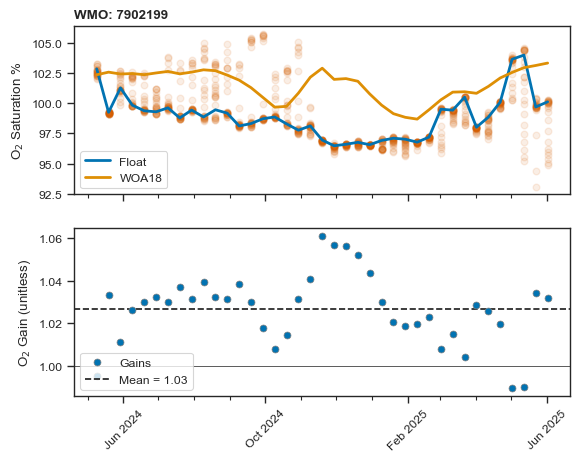

In [15]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
#g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

(200.0, 0.0)

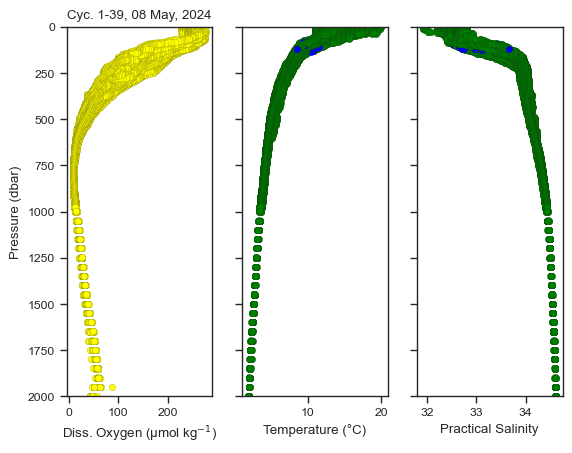

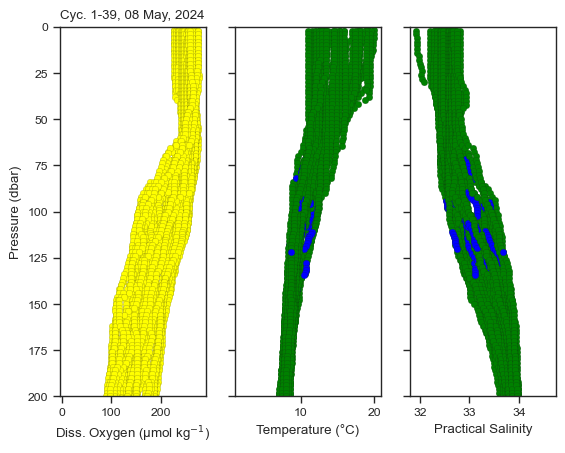

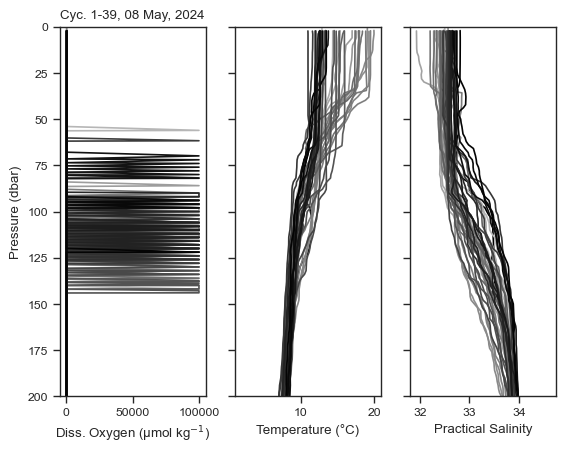

In [17]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
#g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
#g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)
g = flt.plot('profiles', varlist=['DOXY', 'TEMP', 'PSAL'])
g.axes[0].set_ylim((200,0))
#g.fig.savefig(fig_path / 'profiles_shallow.png', bbox_inches='tight', dpi=250)

### Flag bad data, recalculate gain
* Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4.
* After flagging bad data, re-clean the data and re-calculate the gains.

Updating DOXY_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels

Calculating gains using WOA surface data and float O2 percent saturation...
1.0267052382522905


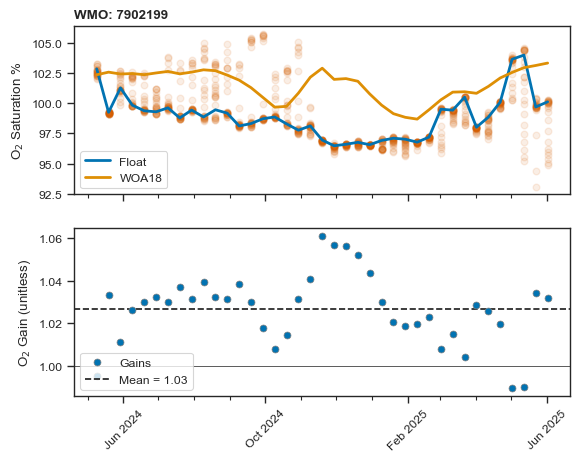

In [18]:
bad_oxygen = [] # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(df['date'], df['flt O2 %sat'], '*')
g.axes[1].plot(df['date'], df['WOA G_raw'], '*', zorder=3)
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
#g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

### Update Fields and Export
* DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
* Apply the gain to calculate DOXY_ADJUSTED.
* Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
* Fill in DOXY_ADJUSTED_QC.
* Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are FillValue wherever DOXY_ADJUSTED_QC is bad.
* Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling bgc.configure.configure().

In [19]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# apply gain and calculate error
flt.update_field('DOXY_ADJUSTED', flt.gain*flt.DOXY)
flt.update_field('DOXY_ADJUSTED_ERROR', bgc.calc_fixed_doxy_adjusted_error(flt.PSAL, flt.TEMP, flt.PRES))
# fill in DOXY_ADJUSTED_QC appropriately
flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC.isin([0, 3]))
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

Updating DOXY_QC on 0 levels
Updating DOXY_ADJUSTED on all levels
Updating DOXY_ADJUSTED_ERROR on all levels
Updating DOXY_ADJUSTED_QC on all levels
Updating DOXY_ADJUSTED_QC on 19905 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED_QC on 0 levels
Updating DOXY_ADJUSTED on 0 levels
Updating DOXY_ADJUSTED_ERROR on 0 levels
